# LSQT-Jupyter

## 1. Introduction

* `LSQT-Jupyter` is a Jupyter notebook demonstrating some practical apects of the linear-scaling quantum transport methods reviewd in Ref. [1].
* The programming language chosen is `Python 3`.
* We will refer to Ref. [1] frequently for the relevant theoretical backgounds.
* This code is only suitable for leanring the methods. For high performance computing, check the `GPUQT` code I wrote: https://github.com/brucefan1983/gpuqt
* This code only considers square lattice with Anderson disoder as the model system. For more general simulations, again check the `GPUQT` code.
* For fans of `Matlab`, check the `lsqt-matlab` code I wrote: https://github.com/brucefan1983/lsqt-matlab

[1] Zheyong Fan, Jose Hugo Garcia, Aron W Cummings, Jose-Eduardo Barrios, Michel Panhans, Ari Harju, Frank Ortmann, and Stephan Roche, Linear Scaling Quantum Transport Methodologies, submitted to Reviews of Modern Physics. https://arxiv.org/abs/1811.07387

## 2. Unit system (We are working in 2D)
* Basic units:
 * Reduced Planck constant $\hbar$ = 1
 * Elementary charge $e$ = 1
 * Energy unit $\gamma=1$ is hopping integral
 * Length unit $a=1$ is the lattice constant
* Derived units:
 * Time: $\hbar/\gamma$
 * Densit of states (DOS) in 2D: $1/\gamma/a^2$
 * Velocity autocorrelation (VAC): $a^2\gamma^2/\hbar^2$
 * Mean square displacement (MSD): $a^2$
 * Electrical conductivity in 2D: $e^2/\hbar$
 * Electrical conductance: $e^2/\hbar$

## 3. Import the needed Python packages

In [1]:
import numpy as np              # used frequently
import matplotlib.pyplot as plt # used for plotting
from scipy import sparse        # crucial for performance
from scipy import special       # for Bessel function

## 4. Construct the tight-binding model
1. We consdier the nearest-neighbor tight-bindng model defined on a square lattice with lattice constant $a$ and dimensions $N=N_x\times N_y$.
2. The Hamiltonian can be written as
$$
\hat{H} = \sum_{ij} (-\gamma) c_i^{\dagger} c_j + \sum_i U_i c_i^{\dagger} c_i,
$$
where $-\gamma$ is the hopping integral and $U_i$ are the on-site potentials. The on-site potentials are uniformly distributed in an interval $[-W/2, W/2]$, where $W$ is the Anderson disorder strength. For simplicity, we consider open boundary conditions in the $y$ direction and study the transorpt in the $x$ direction.

### 4.1 Define an indexing scheme
1. The purpose is to map th 2D indices in the lattice into 1D indices
2. The 1D indices will be used for the Hamiltionian, velcoity operator, and various vectors.
3. This only requires a simple function shown below:

In [2]:
def find_index(nx, ny, Ny):
    index = nx * Ny + ny
    return index

### 4.2. Define the function for creating the sparse Hamiltonian and velocity operator
1. We consider square lattice with $N_x \times N_y$ lattice sites.
2. Use periodic boundary conditions in the $x$ direction.
3. Use open boundary conditions in the $y$ direction.
4. Assume the transport is in the $x$ direction.
5. All the hoppings integral $\gamma=1$ defines the energy units.
6. The lattices constant $a=1$ defines the length units.
7. Anderson diorder strength is $W$, which means that random on-site potentials are uniformly chosen from $[-W/2, W/2]$. $W$ is in units of $\gamma$.

In [3]:
def find_H(Nx, Ny, W):
    N = Nx * Ny; # total number of sites
    row_H = np.zeros(N * 4 - Nx * 2) # the row indices for H
    col_H = np.zeros(N * 4 - Nx * 2) # the column indices for H
    Hij = -np.ones(N * 4 - Nx * 2, complex) # nonzero Hamiltonian elements
    row_V = np.zeros(N * 2) # row indices for V
    col_V = np.zeros(N * 2) # column indices for V
    Vij = np.zeros(N * 2, complex) # nonzero velocity matrix elements
    row_U = np.arange(0, N) # row and column indices for U
    Uij = np.random.uniform(-W * 0.5, W * 0.5, N) # on-site potentials
    count_H = 0 # number of nonzero H elements
    count_V = 0 # number of nonzero V elements
    for nx in range(Nx):
        for ny in range(Ny):
            # (0) # get the index of the center site
            index_center = find_index(nx, ny, Ny)
            # (1) consider the left neighbor (periodic boundary)
            index_left = find_index((nx - 1) % Nx, ny, Ny)
            row_H[count_H] = index_center
            col_H[count_H] = index_left
            count_H += 1
            row_V[count_V] = index_center
            col_V[count_V] = index_left
            Vij[count_V] = 1j
            count_V += 1
            # (2) consider the right neighbor (periodic boundary)
            index_right = find_index((nx + 1) % Nx, ny, Ny)
            row_H[count_H] = index_center
            col_H[count_H] = index_right
            count_H += 1
            row_V[count_V] = index_center
            col_V[count_V] = index_right
            Vij[count_V] = -1j
            count_V += 1
            # (3) consider the upper neighbor (open boundary)
            if ny < Ny - 1:
                index_up = find_index(nx, (ny + 1), Ny)
                row_H[count_H] = index_center
                col_H[count_H] = index_up
                count_H += 1
            # (4) consider the down neighbor (open boundary)
            if ny > 0:
                index_down = find_index(nx, (ny - 1), Ny)
                row_H[count_H] = index_center
                col_H[count_H] = index_down
                count_H += 1
    H = sparse.csr_matrix((Hij, (row_H, col_H)), shape = (N, N))
    U = sparse.csr_matrix((Uij, (row_U, row_U)), shape = (N, N))
    H = H + U
    V = sparse.csr_matrix((Vij, (row_V, col_V)), shape = (N, N))
    return (H, V)

## 5. Create a random state
* In all the LSQT methods, the first crucial step is to use random vector approximation for evaluating the trace of a matrix.
* We use random phase vector, whose elements can be written as $e^{i\theta}=\cos(\theta)+i\sin(\theta)$, where $\theta$ is a random number within $[0, 2\pi]$.

In [4]:
def create_state(N):
    random_phase = np.random.uniform(0, 2 * np.pi, N)
    phi = np.cos(random_phase) + np.sin(random_phase) * 1j; 
    phi = phi / np.linalg.norm(phi);
    return phi

## 6. Calculate the Chebyshev moments
1. The chebyshev moments $C_m$ of the DOS, VAC, and MSD can be uniformly expresseed as
$$
C_m = \langle \phi_L| T_m(\tilde{H}) | \phi_R \rangle,
$$
where $\tilde{H}$ is the scaled Hamiltonian and $T_m$ is the $m$-th order Chebyshev polynomial of the first kind.
2. The differences between the above three quantities are reflected by the different left and right vectors, $\phi_L$ and $\phi_R$.
3. See Algorithm 4 in the review paper.

In [5]:
def find_moments(M, H_scaled, phi_left, phi_right):  
    C = np.zeros(M)
    phi_0 = phi_right
    C[0] = np.vdot(phi_left, phi_0).real
    phi_1 = H_scaled.dot(phi_0)
    C[1] = np.vdot(phi_left, phi_1).real
    for m in range(2, M):
        phi_2 = 2.0 * H_scaled.dot(phi_1) - phi_0
        C[m] = np.vdot(phi_left, phi_2).real
        phi_0 = phi_1
        phi_1 = phi_2
    return C

## 7. Calculate the Chebyshev summation
1. The chebyshev summation gives the final results:
  * DOS: Equation (94) in the review paper
  * DOS times VAC: Equation (100) in the review paper
  * DOS times MSD: Equation (102) in the review paper

### 7.1 The damping factor
1. We only consider the Jackson damping factor.
2. One can compare the figure to that in Fig. 3 of the review paper.

In [6]:
def jackson_damping(M):
    m = np.arange(M)
    a = 1.0 / (M + 1.0)
    g = (1.0 - m * a) * np.cos(np.pi * m * a)
    g += a * np.sin(np.pi * m * a) / np.tan(np.pi * a)
    return g

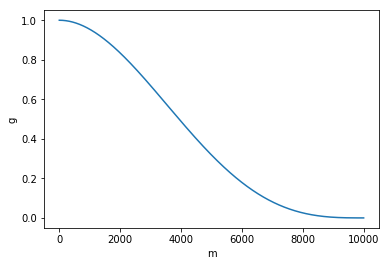

In [7]:
M = 10000
plt.plot(np.arange(M), jackson_damping(M))
plt.xlabel('m')
plt.ylabel('g')
plt.show()

### 7.2 Calculate the Chebyshev summation
1. Check Eqs. (94), (100), and (102) in the review paper.

In [8]:
def chebyshev_summation(M, C, E_scaled, E_max):
    g = jackson_damping(M) # get the damping factor
    C *= g                 # apply the damping factor
    Ne = E_scaled.size     # number of energy points
    T0 = np.ones(Ne)
    T1 = E_scaled
    s = C[1] * T1
    for m in range(2, M):
        T2 = 2.0 * E_scaled * T1 - T0
        T0 = T1
        T1 = T2
        s += C[m] * T2
    s *= 2.0
    s += C[0] * np.ones(Ne)
    s *= 2.0 / (np.pi * np.sqrt(1.0 - E_scaled * E_scaled) * E_max)
    return s

## 8. DOS

In [ ]:
def find_dos(M, E_max, E_scaled, H_scaled, phi):
    C = find_moments(M, H_scaled, phi, phi)
    DOS = chebyshev_summation(M, C, E_scaled, E_max)
    return DOS

## 9. Time evolution
1. To calculate transport properties (VAC, MSD), we need to consider time evolution
2. For the time evolution operator $\hat{U}(\pm \Delta t)$, see Eqs. (73) and (74) in the review paper.
2. For the time evolution operator $[X, \hat{U}(\Delta t)]$, see Eqs. (75) and (76) in the review paper.

### 9.1. Evaluating $|\phi_{\rm out}\rangle = \hat{U}(\pm \Delta t) |\phi_{\rm in}\rangle$
1. The implementation below follows Algorithm 1 in the review paper.
2. For the Bessel function of the first kind, we use scipy.special.jv(n, x).

In [ ]:
def evolve(H_scaled, dt_scaled, sign, phi_i):
    phi_0 = phi_i
    phi_1 = H_scaled.dot(phi_i)
    j0 = special.jv(0, dt_scaled)
    j1 = special.jv(1, dt_scaled)
    phi_o = j0 * phi_0 + 2.0 * (-1j * sign) * j1 * phi_1
    m = 2
    while True:
        jm = special.jv(m, dt_scaled)
        if abs(jm) < 1.0e-15:
            break
        phi_2 = 2.0 * H_scaled.dot(phi_1) - phi_0
        phi_o += 2.0 * (-1j * sign) ** m * jm * phi_2
        phi_0 = phi_1
        phi_1 = phi_2
        m += 1
    return phi_o


### 9.2. Evaluating $|\phi_{\rm out}\rangle = [X, \hat{U}(\Delta t)] |\phi_{\rm in}\rangle$
1. The implementation below follows Algorithm 2 in the review paper.
2. For the Bessel function of the first kind, we use scipy.special.jv(n, x).

In [ ]:
def evolvex(H_scaled, V_scaled, dt_scaled, phi_i):
    phi_0 = phi_i
    phix_0 = phi_i * 0.0
    phi_1 = H_scaled.dot(phi_0)
    phix_1 = 1j * V_scaled.dot(phi_0)
    phi_o = (-2.0j) * special.jv(1, dt_scaled) * phix_1
    m = 2
    while True:
        jm = special.jv(m, dt_scaled)
        if abs(jm) < 1.0e-15:
            break
        phi_2 = 2.0 * H_scaled.dot(phi_1) - phi_0
        phix_2 = 2.0j * V_scaled.dot(phi_1)
        phix_2 += 2.0 * H_scaled.dot(phix_1) - phix_0
        phi_o += 2.0 * (-1j) ** m * jm * phix_2
        phi_0 = phi_1 
        phi_1 = phi_2
        phix_0 = phix_1
        phix_1 = phix_2
        m += 1
    return phi_o

## 10. VAC and related quantites

In [ ]:
def find_vac(M, E_max, dt_scaled, E_scaled, H_scaled, V, phi, DOS):
    Ne = E_scaled.size  # number of energy points
    Nt = dt_scaled.size # number of time steps
    dt = dt_scaled / E_max
    phi_left = phi
    phi_right = V.dot(phi)
    DOS_times_VAC = np.zeros(Ne)
    VAC = np.zeros((Nt, Ne))
    sigma_from_VAC = np.zeros((Nt, Ne))
    for nt in range(Nt):
        C = find_moments(M, H_scaled, V.dot(phi_left), phi_right)
        DOS_times_VAC = chebyshev_summation(M, C, E_scaled, E_max)
        VAC[nt, :] = DOS_times_VAC / DOS
        if nt > 0:
            sigma_from_VAC[nt, :] = sigma_from_VAC[nt - 1, :] + dt[nt] * DOS_times_VAC
        phi_left = evolve(H_scaled, dt_scaled[nt], -1, phi_left)
        phi_right = evolve(H_scaled, dt_scaled[nt], -1, phi_right)
    sigma_from_VAC *= 2.0 * np.pi
    return VAC, sigma_from_VAC

## 11. MSD and related quantites

In [ ]:
def find_msd(M, E_max, dt_scaled, E_scaled, H_scaled, V_scaled, phi, DOS):
    Ne = E_scaled.size  # number of energy points
    Nt = dt_scaled.size # number of time steps
    dt = dt_scaled / E_max
    MSD = np.zeros((Nt, Ne))
    sigma_from_MSD = np.zeros((Nt, Ne))
    phix = phi * 0.0
    DOS_times_MSD_old = np.zeros(Ne)
    DOS_times_MSD_new = np.zeros(Ne)
    for nt in range(Nt):
        phix = evolve(H_scaled, dt_scaled[nt], 1, phix);
        phix += evolvex(H_scaled, V_scaled, dt_scaled[nt], phi);
        phi = evolve(H_scaled, dt_scaled[nt], 1, phi);
        C = find_moments(M, H_scaled, phix, phix);
        DOS_times_MSD_new = chebyshev_summation(M, C, E_scaled, E_max);
        MSD[nt, :] = DOS_times_MSD_new / DOS
        sigma_from_MSD[nt, :] = (DOS_times_MSD_new - DOS_times_MSD_old) / dt[nt] * 0.5
        DOS_times_MSD_old = DOS_times_MSD_new
    sigma_from_MSD *= 2.0 * np.pi # from e^2/hbar to e^2/h
    return MSD, sigma_from_MSD

## 12. Example 1: ballistic transport
1. We will try to get a similar plot as in Figs. 5 and 6 in the review paper.
2. Note that the results in the review paper were obained using the efficient GPUQT code. So there are some differences in the parameters chosen:
 * The number of sites in the review paper is 10 times as large as that in this example.
 * The number of moments is 3000 in the review paper, while it is 1000 here.
 * The results in the review paper were obtained by averaging over 10 random vectors, while we only use a single random vector below.
3. Therefore, the results in the review paper are more accurate.

In [ ]:
# (1) Prepare some parameters
Nx = 500000                       # length
Ny = 2                            # width
W = 0                             # no disorder in this example
E_max = 3.1                       # energy scaling factor (can be determined by try and error)
M = 1000                          # number of Chebyshev moments
E = np.linspace(-3, 3, num = 601) # energy points
Nt = 10                           # number of time steps
dt = np.ones(Nt)                  # time steps
t_VAC = np.arange(10.0)           # time for VAC
t_MSD = np.arange(10.0) + 0.5     # time for MSD

# (2) Calculate quantities
H, V = find_H(Nx, Ny, W)                        # Hamiltonian and velocity
phi = create_state(Nx * Ny)                     # initial random state
DOS = find_dos(M, E_max, E/E_max, H/E_max, phi) # DOS
VAC, sigma_from_VAC = find_vac(M, E_max, dt*E_max, E/E_max, H/E_max, V, phi, DOS)
MSD, sigma_from_MSD = find_msd(M, E_max, dt*E_max, E/E_max, H/E_max, V/E_max, phi, DOS)
v = np.sqrt(VAC[0, :])                          # Fermi velocity
g = Ny * DOS * v * 0.5                          # conductance
g *= 2.0 * np.pi                                # from e^2/hbar to e^2/h

# (3) Plot a similar figure as in Fig. 5 in the review paper
plt.figure

ax1 = plt.subplot(2, 2, 1)
plt.plot(t_VAC, VAC[:, 301], 'bo')
plt.xlabel('Time ($\hbar/\gamma$)')
plt.ylabel('VAC ($a^2\gamma^2/\hbar^2$)')
plt.ylim(0, 4)

ax2 = plt.subplot(2, 2, 2)
plt.plot(t_MSD, MSD[:, 301], 'bo')
plt.xlabel('Time ($\hbar/\gamma$)')
plt.ylabel('MSD ($a^2$)')

ax2 = plt.subplot(2, 2, 3)
plt.plot(E, DOS)
plt.xlabel('Energy ($\gamma$)')
plt.ylabel('DOS ($1/\gamma/a^2$)')

ax2 = plt.subplot(2, 2, 4)
plt.plot(E, v)
plt.xlabel('Energy ($\gamma$)')
plt.ylabel('v ($a\gamma/\hbar$)')

plt.show()

# (4) Plot the a similar figure as in Fig. 6 in the review paper
plt.figure
plt.plot(E, g)
plt.xlabel('Energy ($\gamma$)')
plt.ylabel('g ($e^2/h$)')
plt.show()

## 13. Example 2: diffusive transport
1. We will try to get a similar plot as in Figs. 7 in the review paper.
2. TODO